# Prepare the data

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data(
    path='mnist.npz'
)

11493376/11490434 [==============================] - 0s 0us/step


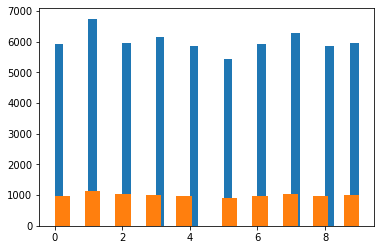

In [3]:
import matplotlib.pyplot as plt
_ = plt.hist(train_labels, bins='auto') 
_ = plt.hist(test_labels, bins='auto')

In [4]:
test_images = test_images.reshape(test_images.shape[0],28,28,1)
train_images = train_images.reshape(train_images.shape[0],28,28,1)
test_images.shape, train_images.shape

((10000, 28, 28, 1), (60000, 28, 28, 1))

In [5]:
train_images = train_images / 255.0
test_images = test_images / 255.0

# Model

In [6]:
input_shape = (28, 28, 1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Normal training with all the data, to check that everything works as expected

In [8]:
labelled_indices = np.sort(np.random.choice(np.arange(len(train_labels)),60000,replace=False))
model.fit(train_images[labelled_indices], train_labels[labelled_indices], validation_data = (test_images,  test_labels), epochs=5, verbose = 1)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


1875/1875 [==============================] - 39s 4ms/step - loss: 0.2348 - accuracy: 0.9315 - val_loss: 0.0434 - val_accuracy: 0.9859
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0943 - accuracy: 0.9725 - val_loss: 0.0324 - val_accuracy: 0.9889
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0773 - accuracy: 0.9782 - val_loss: 0.0295 - val_accuracy: 0.9911
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0695 - accuracy: 0.9800 - val_loss: 0.0301 - val_accuracy: 0.9905
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0569 - accuracy: 0.9840 - val_loss: 0.0329 - val_accuracy: 0.9893


# Compute uncertainty with dropout sampling

In [9]:
import tqdm
def most_uncertain_samples(model_, unlabelled_data: np.array, num_useful_examples: int, 
                           dropout_sampling_runs: int, batch_size = 128):
  """
  Given a model and some unlabelled samples, performs dropout sampling and 
  selects the examples that show highest classification uncertainty.
  """
  sum_max_array = np.array([])
  for array_index in tqdm.tqdm(range(0,len(unlabelled_data),batch_size)):
    # Reduce the batch size when there are not enough samples left
    real_batch_size = min(len(unlabelled_data) - array_index, batch_size)
    result = np.zeros((real_batch_size,10))
    batch_images = unlabelled_data[array_index:array_index+real_batch_size].reshape(
          real_batch_size,28,28,1)
    outputs_ = model_(batch_images, training=False)
    predictions = np.argmax(outputs_)
    for i in range(dropout_sampling_runs):
      # Inference with dropout enabled
      outputs = model_(batch_images, training=True)
      result += outputs
    amax_sum = np.amax(result,axis=1)
    sum_max_array = np.append(sum_max_array, amax_sum)

  # return the indices of the lowest sums (the most uncertain examples), hopefully most useful
  return np.argsort(sum_max_array)[:num_useful_examples]

# Active learning

In [10]:
initially_labelled_examples = 70
active_learning_steps = 5
interesting_examples_each_step = 10
labelled_indices = np.array([]) 
unlabelled_indices = np.arange(len(train_labels))
dropout_sampling_runs = 10
  
# Initial labelling
labelled_indices = np.sort(np.random.choice(unlabelled_indices,initially_labelled_examples,replace=False))
unlabelled_indices = np.delete(unlabelled_indices, labelled_indices)

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
al_model = tf.keras.models.clone_model(model)
al_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 


# Active learning loop

for active_learning_step in range(0,active_learning_steps):
  if active_learning_step > 0:
    al_model.load_weights(checkpoint_filepath)
  al_model.fit(train_images[labelled_indices], train_labels[labelled_indices], validation_data = (test_images,  test_labels), 
               epochs=210, callbacks=[model_checkpoint_callback])
  al_model.load_weights(checkpoint_filepath)

  # Evaluation on test dataset
  test_loss, test_accuracy = al_model.evaluate(test_images, test_labels, batch_size=64)
  print(f'Test loss: {test_loss} accuracy: {test_accuracy} obtained with {labelled_indices.shape} labelled samples')

  # Let's find which are the hard examples
  data_to_label  = most_uncertain_samples(al_model, train_images[unlabelled_indices], interesting_examples_each_step, dropout_sampling_runs, batch_size=128)
  print('data_to_label',data_to_label.shape, 'unlabelled_indices[data_to_label]',unlabelled_indices[data_to_label].shape )
  
  # Let's send the data to labelling
  labelled_indices = np.append(labelled_indices,unlabelled_indices[data_to_label])
  print('labelled_indices',labelled_indices.shape)
  unlabelled_indices = np.delete(unlabelled_indices,data_to_label)
  print('unlabelled_indices',unlabelled_indices.shape)


Epoch 1/210


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


3/3 [==============================] - 2s 463ms/step - loss: 4.2706 - accuracy: 0.1571 - val_loss: 2.2860 - val_accuracy: 0.1801
Epoch 2/210
3/3 [==============================] - 1s 301ms/step - loss: 2.8083 - accuracy: 0.2857 - val_loss: 2.2621 - val_accuracy: 0.2965
Epoch 3/210
3/3 [==============================] - 1s 322ms/step - loss: 1.6489 - accuracy: 0.5143 - val_loss: 2.2482 - val_accuracy: 0.3562
Epoch 4/210
3/3 [==============================] - 1s 322ms/step - loss: 1.3115 - accuracy: 0.6000 - val_loss: 2.2381 - val_accuracy: 0.3729
Epoch 5/210
3/3 [==============================] - 1s 322ms/step - loss: 1.0433 - accuracy: 0.6714 - val_loss: 2.2259 - val_accuracy: 0.3721
Epoch 6/210
3/3 [==============================] - 1s 292ms/step - loss: 1.0538 - accuracy: 0.6571 - val_loss: 2.2121 - val_accuracy: 0.4114
Epoch 7/210
3/3 [==============================] - 1s 289ms/step - loss: 0.7825 - accuracy: 0.7429 - val_loss: 2.1996 - val_accuracy: 0.4506
Epoch 8/210
3/3 [========

100%|██████████| 469/469 [00:30<00:00, 15.41it/s]


data_to_label (10,) unlabelled_indices[data_to_label] (10,)
labelled_indices (80,)
unlabelled_indices (59920,)
Epoch 1/210
3/3 [==============================] - 1s 355ms/step - loss: 0.4590 - accuracy: 0.8875 - val_loss: 0.8301 - val_accuracy: 0.7636
Epoch 2/210
3/3 [==============================] - 1s 324ms/step - loss: 0.4201 - accuracy: 0.8875 - val_loss: 0.8444 - val_accuracy: 0.7600
Epoch 3/210
3/3 [==============================] - 1s 297ms/step - loss: 0.2213 - accuracy: 0.9375 - val_loss: 0.8032 - val_accuracy: 0.7732
Epoch 4/210
3/3 [==============================] - 1s 295ms/step - loss: 0.0586 - accuracy: 0.9875 - val_loss: 0.7653 - val_accuracy: 0.7873
Epoch 5/210
3/3 [==============================] - 1s 304ms/step - loss: 0.0911 - accuracy: 0.9750 - val_loss: 0.7132 - val_accuracy: 0.8020
Epoch 6/210
3/3 [==============================] - 1s 324ms/step - loss: 0.0713 - accuracy: 0.9750 - val_loss: 0.6795 - val_accuracy: 0.8102
Epoch 7/210
3/3 [==========================

100%|██████████| 469/469 [00:30<00:00, 15.30it/s]


data_to_label (10,) unlabelled_indices[data_to_label] (10,)
labelled_indices (90,)
unlabelled_indices (59910,)
Epoch 1/210
3/3 [==============================] - 1s 388ms/step - loss: 0.3776 - accuracy: 0.9000 - val_loss: 0.6112 - val_accuracy: 0.8455
Epoch 2/210
3/3 [==============================] - 1s 322ms/step - loss: 0.4347 - accuracy: 0.9000 - val_loss: 0.6499 - val_accuracy: 0.8406
Epoch 3/210
3/3 [==============================] - 1s 271ms/step - loss: 0.1166 - accuracy: 0.9556 - val_loss: 0.7445 - val_accuracy: 0.8216
Epoch 4/210
3/3 [==============================] - 1s 297ms/step - loss: 0.0730 - accuracy: 0.9778 - val_loss: 0.8466 - val_accuracy: 0.8020
Epoch 5/210
3/3 [==============================] - 1s 289ms/step - loss: 0.0281 - accuracy: 1.0000 - val_loss: 0.9073 - val_accuracy: 0.7882
Epoch 6/210
3/3 [==============================] - 1s 323ms/step - loss: 0.0603 - accuracy: 0.9778 - val_loss: 0.9359 - val_accuracy: 0.7795
Epoch 7/210
3/3 [==========================

100%|██████████| 469/469 [00:29<00:00, 15.77it/s]


data_to_label (10,) unlabelled_indices[data_to_label] (10,)
labelled_indices (100,)
unlabelled_indices (59900,)
Epoch 1/210
4/4 [==============================] - 1s 269ms/step - loss: 0.4698 - accuracy: 0.9100 - val_loss: 0.6701 - val_accuracy: 0.8562
Epoch 2/210
4/4 [==============================] - 1s 216ms/step - loss: 0.1690 - accuracy: 0.9500 - val_loss: 0.8029 - val_accuracy: 0.8296
Epoch 3/210
4/4 [==============================] - 1s 202ms/step - loss: 0.0271 - accuracy: 0.9900 - val_loss: 0.9037 - val_accuracy: 0.8063
Epoch 4/210
4/4 [==============================] - 1s 217ms/step - loss: 0.0527 - accuracy: 0.9800 - val_loss: 0.8980 - val_accuracy: 0.8054
Epoch 5/210
4/4 [==============================] - 1s 217ms/step - loss: 0.0898 - accuracy: 0.9600 - val_loss: 0.8087 - val_accuracy: 0.8193
Epoch 6/210
4/4 [==============================] - 1s 203ms/step - loss: 0.0346 - accuracy: 0.9900 - val_loss: 0.6888 - val_accuracy: 0.8449
Epoch 7/210
4/4 [=========================

100%|██████████| 468/468 [00:29<00:00, 16.06it/s]

data_to_label (10,) unlabelled_indices[data_to_label] (10,)
labelled_indices (110,)
unlabelled_indices (59890,)
Epoch 1/210
1/4 [======>.......................] - ETA: 0s - loss: 0.2170 - accuracy: 0.9688

4/4 [==============================] - 1s 239ms/step - loss: 0.4471 - accuracy: 0.9182 - val_loss: 0.6404 - val_accuracy: 0.8944
Epoch 2/210
4/4 [==============================] - 1s 194ms/step - loss: 0.0953 - accuracy: 0.9636 - val_loss: 0.6148 - val_accuracy: 0.8966
Epoch 3/210
4/4 [==============================] - 1s 200ms/step - loss: 0.0735 - accuracy: 0.9545 - val_loss: 0.5958 - val_accuracy: 0.9014
Epoch 4/210
4/4 [==============================] - 1s 198ms/step - loss: 0.1319 - accuracy: 0.9545 - val_loss: 0.5984 - val_accuracy: 0.8984
Epoch 5/210
4/4 [==============================] - 1s 202ms/step - loss: 0.0884 - accuracy: 0.9545 - val_loss: 0.6485 - val_accuracy: 0.8882
Epoch 6/210
4/4 [==============================] - 1s 203ms/step - loss: 0.0995 - accuracy: 0.9636 - val_loss: 0.6801 - val_accuracy: 0.8847
Epoch 7/210
4/4 [==============================] - 1s 200ms/step - loss: 0.0554 - accuracy: 0.9818 - val_loss: 0.6977 - val_accuracy: 0.8849
Epoch 8/210
4/4 [========

100%|██████████| 468/468 [00:30<00:00, 15.27it/s]

data_to_label (10,) unlabelled_indices[data_to_label] (10,)
labelled_indices (120,)
unlabelled_indices (59880,)
